# Lab Semantic Segmentation

Welcome to the Semantic Segmentation lab! During this session, you'll gain insights into employing pretrained models for conducting segmentation on the Cityscapes dataset.
<center>
  <img src="img/segmentation.png" style="width:700px;height:400;">
</center>
<caption><center> <u><b> Figure 1 </u></b>: Semantic segmentation <br> </center></caption>
In essence, our objective is to take an RGB color image and generate a segmentation mask. This mask will assign each pixel a class label, represented as an integer.
    
**In this assignment, you will:**
- Implement function for the evaluation metrics
- Preprocess raw images and segmentation mask
- Make predictions with the pretrained models (FCN and Unet) and visualize segmentation masks.
- Compare model performances. 

In most exercises, a suggested outline will be provided for you, and each exercise are expected to be solved within 15 lines.

Please note that you are restricted to using the packages already loaded and the custom functions explained in the notebook. Run the cell below to import the necessary packages.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor
import torchvision.transforms as transforms

from PIL import Image
from glob import glob

# load image path
image_path = glob('cityscapes_data/*.jpg')

# 1 Evaluation Metrics (IOU)
Before we dive into the models for semantic segmentation, lets us first determine the evaluation metrics, specifically intersection over Union, which computes pixelwise agreement between the true mask and prediction: $$ IoU(X, X_{truth}) = \frac{|X \cap X_{truth}|}{|X \cup X_{truth}|} = \frac{|X \cap X_{truth}|}{|X|+ |X_{truth}| - |X \cap X_{truth}|} $$The following exercise requires you to design an evaluation metric function, and for simplicity, it only involves 3 classes (class 0, class 1, and class 2) and 10 by 10 images.   

**Exercise：** Implement IOU function as an evaluation metric

In [3]:
def IOU(prediction, GT):
    """ Intersection Over Unions
    Arguments:
        GT -- ground truth label, dimension: (Batch size, number of class, width, height)
        prediction -- predicted segmentation, dimension: (Batch size, number of class, width, height)    
    Returns:
        IOU for the class
    """
    eps = 1e-5 # remember to add a small number to denominator to avoid division by 0
    # YOUR CODE STARTS HERE
    # Intersection term  |A ^ B|
    inter = 
    
    # sum of |A| + |B|
    sets_sum = 
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)
  

In [4]:
# Tests 
GT = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
                   [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
                   [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
                   [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 2., 2.],
                   [0., 0., 2., 2., 2., 2., 2., 2., 2., 2.],
                   [0., 0., 2., 2., 2., 2., 2., 2., 2., 2.]]).long()

Prediction = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
                   [0., 0., 0., 0., 2., 1., 1., 1., 0., 0.],
                   [0., 0., 0., 1., 1., 2., 1., 0., 0., 0.],
                   [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 1., 1., 0., 0., 0., 2., 0.],
                   [2., 2., 2., 1., 1., 1., 1., 2., 2., 0.],
                   [2., 2., 2., 2., 2., 2., 2., 2., 0., 0.]]).long()

score = IOU(F.one_hot(Prediction).unsqueeze(0).float(), F.one_hot(GT).unsqueeze(0).float()).item()
assert np.isclose(0.7094017267227173, score), 'incorrect result!'
print("\033[92m All tests passed!")

 All tests passed!


# 2 Data preprocessing
### Cityscapes Dataset
Cityscapes is a computer vision dataset for urban scene understanding. It includes high-resolution images from various cities in Europe, densely annotated with 30 semantic classes such as roads, buildings, cars, and pedestrians. It's widely used to develop and evaluate algorithms for autonomous vehicles and urban planning. We will its fine annotated samples, in which raw data and segmentation masks are concatenated in the same images. First, lets inspect a few samples:


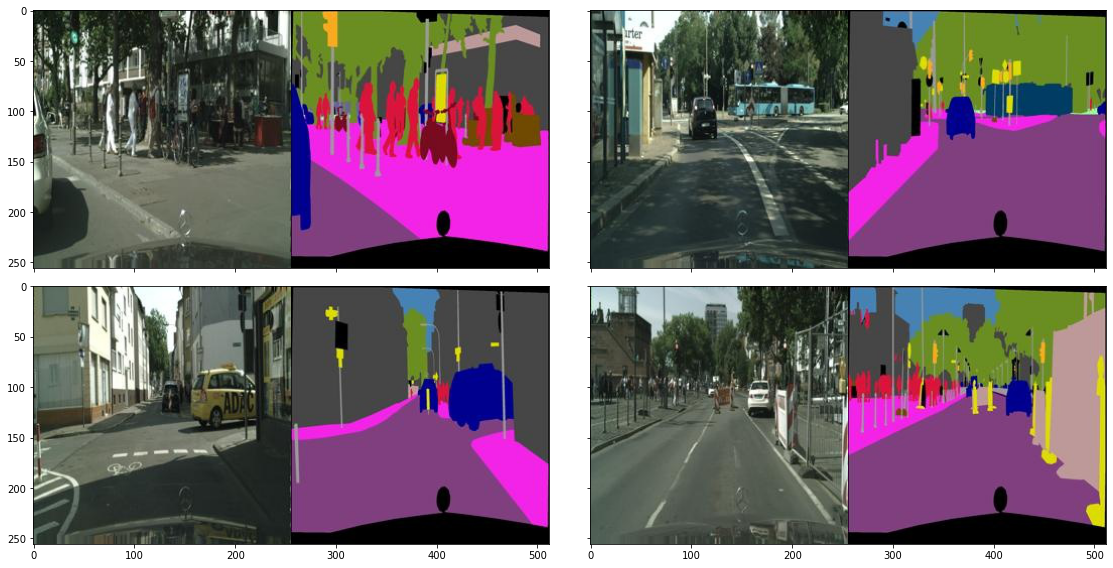

In [5]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 8))
for i in range(4):
    # read the image
    img = torchvision.io.read_image(image_path[i])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // 2, i % 2
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

### Preprocessing
Unfortunately, raw images and segmentation masks are paired in RGB images, so we need split them and label masks. After preprocessing, the segmentation mask should have a shape of (256, 256). Additionally, to enhance inference speed, both the images and masks are resized to a more manageable size of (128, 128, 3) and (128, 128), respectively.

**Exercise:** Preprocess the data
1. Split raw images and masks
2. label masks 

In [6]:
# total classes name
names = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']

# colours in the segmentation mask
idx_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_color_np = np.array(idx_color)
# mappings, note that several classes might be mapped to the same number as we are not interested in unlabeled, ego vehicle, etc.
mapping = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

from typing import Tuple
# vectorize the operation of getting the class index to class number for numpy 
idx_to_category_mapping = lambda x: mapping[x]
vectorized_cat_mapping = np.vectorize(idx_to_category_mapping)

# vectorize the operation of mapping the class index to color for numpy 
idx_to_col_mapping = lambda x: idx_color[x]
vectorized_col_mapping = np.vectorize(idx_to_col_mapping)


In [7]:
# Preprocessing function
def preprocess_image(path : str, downscale_factor=1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or class id representation (128 x 128)
        Argmument: 
            path: the path to the image
            downscale_factor: factor to resize the image
        Return:
            raw: resized raw image
            mask: original mask in RGB
            classes: new classes mask (single channel)
    """
    # Read the image from path.
    img = Image.open(path)
    width, height = img.size
    
    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height))
    
    img = np.asarray(img)    
    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    # YOUR CODE STARTS HERE
    raw, mask = 
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel in mask) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = 
    classes = 

    # if we want to operate on names, map the categories to class number
    classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


size of input :  (128, 128, 3)
size of mask raw :  (128, 128, 3)
size of classes :  (128, 128)


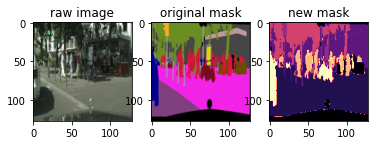

In [8]:
x, mask_raw, classes = preprocess_image(image_path[0], downscale_factor=2)
# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)

plt.subplot(1, 3, 1)
plt.title('raw image')
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.title('original mask')
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.title('new mask')
plt.imshow(classes, cmap='magma')
plt.show()

In [9]:
# convert to torch tensor
input_images = []
masks = []
# input image is normalized according to imagenet
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for path in image_path:
    X, _, Y = preprocess_image(path, downscale_factor=2)
    input_images.append(transform(torch.Tensor(X / 255.).permute(2, 0, 1)))
    masks.append(torch.Tensor(Y))

input_images = torch.stack(input_images)
masks = torch.stack(masks)

# Fully Convolutional Network (FCN) with naive upsampling
<center>
  <img src="img/FCN.png" style="width:700px;height:400;">
</center>
<caption><center> <u><b> Figure 2 </u></b>: Fully Convolutional Neural Networks Architecture  <br> </center></caption>

Now we are ready to feed the model with the processed images. The actual architeture of the model is not exactly the same as Figure 2, so if you are interested in its implementation please check `model/NaiveNet.py`.

**Exercise:**
1. Make inference with FCN
2. Visualize predictions

In [10]:
from models.NaiveNet import NaiveNet
model_Naive = NaiveNet(n_channels=3, n_classes=len(set(mapping.values())))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#load weights from the pretrained model
pretrained_weights = torch.load('models/naiveNet.pth')
model_Naive.load_state_dict(pretrained_weights)
model_Naive.to(device);

In [11]:
def show_inference(batch, GT, predictions):
    """ function to visualize input image, true masks and predicted masks"""
    
    batch_size = batch.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[i], GT[i]  
        img = img.permute(1,2, 0) * Tensor([0.229, 0.224, 0.225]) + Tensor([0.485, 0.456, 0.406])
        axes[i,0].imshow(img)
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")

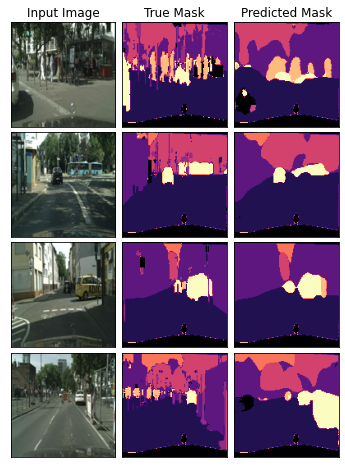

In [12]:
# make predictions
with torch.no_grad():
    prediction_Naive = model_Naive(input_images.to(device))
show_inference(input_images, masks, prediction_Naive)

# 3 Unet Model 
<center>
  <img src="img/Unet.png" style="width:600px;height:260;">
</center>
<caption><center> <u><b> Figure 3 </u></b>: Fully Convolutional Neural Networks Architecture  <br> </center></caption>
U-Net is a popular convolutional neural network (CNN) architecture designed for semantic image segmentation tasks. The U-Net architecture uses skip connections that pass feature maps from the contracting path to the corresponding layers in the expansive path. These skip connections help to retain high-resolution information, aiding in better localization of segmentation boundaries. 
If you like to know more about Unet, here is the link to the paper:
https://arxiv.org/abs/1505.04597?ref=jeremyjordan.me
    
**Exercise:**
1. Make inferences with Unet 
2. Visualize predictions

In [13]:
from models.Unet import Unet
# initilize the Unet
model_Unet = Unet(n_channels=3, n_classes=len(set(mapping.values())))

#load weights from the pretrained model
pretrained_weights = torch.load('models/unet.pth')
model_Unet.load_state_dict(pretrained_weights)
model_Unet.to(device);

In [14]:
# make inference
with torch.no_grad():
    prediction_Unet = model_Unet(input_images.to(device))

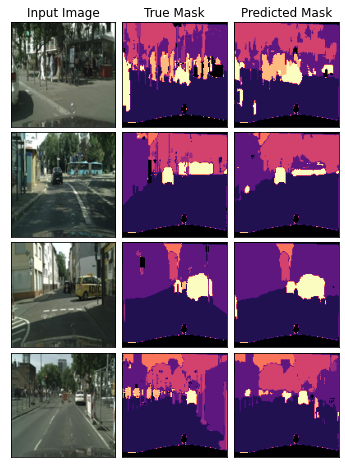

In [15]:
show_inference(input_images, masks, prediction_Unet)

# Model comparison 
As evident from the results, the FCN's performance is inferior to that of the Unet. However, to ensure a more rigorous comparison, we still require appropriate metrics.

**Exercise:**
1. Evaluate and compare the performance of two models


In [16]:
def evaluate(model_name, prediction, mask):
    """
    evaluate model performance using cross entropy and IOU
    Arguments:
        model_name:
        prediction: predicted segmentation
        mask: groud truth mask
    """
    criterion = nn.CrossEntropyLoss()
    CE = criterion(prediction.to(device), masks.to(device).long())
    # YOUR CODE STARTS HERE
    iou = 
    print(f'{model_name}: \n Cross entropy: {CE} \n IOU: {iou} \n')

In [17]:
evaluate('Unet', prediction_Unet, masks)
evaluate('FCN', prediction_Naive, masks)

Unet: 
 Cross entropy: 0.5116177797317505 
 IOU: 0.6931676864624023 

FCN: 
 Cross entropy: 0.5907893180847168 
 IOU: 0.6644637584686279 



If you observe a lower cross-entropy for Unet, but a reduced IOU for FCN, well done, you've successfully completed this lab. you can checkout the references if you want to train a Unet from scratch. Unet is a very basic CNN model for semantic segmentation, while more advanced models currently are based on Visual transformers (Vit).If you are insterested in the latest models, here is a link to the leader board of the semantic segmention: https://paperswithcode.com/task/semantic-segmentation.

## Reference
1. Semantic segmentation post https://medium.com/@karansjc1/semantic-segmentation-using-pytorch-and-opencv-a98d8ddab228
2. Traing Unet https://github.com/mlewandowski0/SemanticSegmentation
3. Overview of Semantic Segmentation methods https://datahacker.rs/020-overview-of-semantic-segmentation-methods/